# Analyse Bleu/Rouge 

In [71]:
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
from sacrebleu import BLEU
from rouge import Rouge 
import matplotlib.pyplot as plt
import random
from reco_systems.evaluation import _hide_ratings_full_matrix
from reco_systems.filter import filter_df
import reco_systems.text_filtering as ft
from reco_systems.user_game_matrix import *
from itertools import product
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import NMF, Dataset
from surprise.reader import Reader
import seaborn as sns

from reco_systems.filter import filter_df
import reco_systems.text_filtering as ft
from reco_systems.user_game_matrix import *
from reco_systems.CF_knn import *
from reco_systems.evaluation import *

from random import choice

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Database, Matrix and NMF Model Loading

In [72]:
# Construction de la BDD avec avis centrés
avis = pd.read_csv("../database_cleaned/avis_clean.csv", index_col = 0)
min_reviews = 20

lemmas = pd.read_csv('../generated_data/avis_lemmatized.csv',index_col=0)
rev_filter = avis[ np.isin(avis.index,lemmas.index.to_numpy())]

rev_filter = filter_df(rev_filter, min_reviews)

filtered_centrd_data, _= center_score(rev_filter)

np.random.seed(42)
matrix_ratings, mask_ratings, users_table, games_table = get_matrix_user_game(filtered_centrd_data)
hidden_users, hidden_games = _hide_ratings_full_matrix(matrix_ratings.todok(), mask_ratings.todok())
games_table = pd.DataFrame(games_table)
users_table = pd.DataFrame(users_table)

user_inds = filtered_centrd_data[['User id', 'Game id']].groupby("User id").count().reset_index()
user_inds.columns = ["User id", "Count reviews"]
assoc = users_table.merge(user_inds, on="User id", how="left").reset_index()
assoc.columns = ["User index", "User id", "Count reviews"]
assoc.sort_values(by='Count reviews', ascending=False,inplace=True)

sim_matrix = calc_similarity_matrix(matrix_ratings, mask_ratings, dist_type="cos")

1945 2614
1123 1275
920 1191
897 1178
892 1174
891 1174


In [50]:
assoc

,User index,User id,Count reviews
77,77,208,681
19,19,83,505
73,73,201,439
25,25,91,409
1,1,1,397
...,...,...,...
115,115,446,20
523,523,2514,20
624,624,3009,20
676,676,3238,20


In [73]:
model = NMF(n_factors=20, random_state=42, biased=False, reg_pu= 0.1, reg_qi= 0.1)
data = Dataset.load_from_df(rev_filter[["User id", "Game id", "Rating"]], reader=Reader(rating_scale=(0, 10)))
trainset = data.build_full_trainset()
nmf = model.fit(trainset)

# Extract matrices
U = nmf.pu  # User-feature matrix (W)
G = nmf.qi  # Item-feature matrix (H)

games_ids = np.array([trainset.to_raw_iid(i) for i in range(len(G))])
users_ids = np.array([trainset.to_raw_uid(u) for u in range(len(U))])
U = U[np.argsort(users_ids), :]
G = G[np.argsort(games_ids), :]

U_similarities = cosine_similarity(U)
R_hat = U @ G.T


In [90]:

ind_to_id = np.vectorize(lambda x : users_table.iloc[x]['User id'])
user_id_to_ind = np.vectorize(lambda x : users_table[users_table['User id'] == x].index[0])


def find_games(user_ind : int) -> list[int]:
    """
    Finds games for a given user_id using their neighbours' ratings.

    Parameters:
    -----------
        data : the database with users' ratings
        user_ref_id : Reference user's ID
        neighbours_id : Reference user's neighbours' ID
        nbj : number of games returned 

    Returns : 
    ----------
        int : The recommended game(s)'s IDs
    """

    # Code Amélie ------------------------------------

    #user_ind = users_table[users_table == user_ref_id].index[0]

    # previous 
    prev_ratings, prev_mask_ratings = matrix_ratings[user_ind, :] , mask_ratings[user_ind, :]
    prev_sim = sim_matrix[user_ind, :]

    hidden_games = hide_ratings(matrix_ratings, mask_ratings, user_ind, 0.1) # hide 10 percent of user's game
    
    recalc_cos_similarity(user_ind, matrix_ratings, sim_matrix)

    # choice of similar users
    knn_all_user = get_KNN(sim_matrix, users_table.shape[0], user_ind)
    sim_users = knn_all_user[:40]

    # prediction
    pred_ratings, mask_pred_ratings = predict_ratings_baseline(matrix_ratings, mask_ratings,
                                                                sim_users, sim_matrix, user_ind)
    hidden_games = np.intersect1d(hidden_games, mask_pred_ratings)
    # restore
    matrix_ratings[user_ind, :], mask_ratings[user_ind, :] = prev_ratings, prev_mask_ratings
    sim_matrix[user_ind, :], sim_matrix[:, user_ind] = prev_sim, prev_sim

    return sim_users, hidden_games, pred_ratings

    # ---------------------------------------





    neighbours_ratings = data[(data['User id']).isin(neighbours_id) | (data['User id'] == user_ref_id)]
    user_ref_games = data[data['User id'] == user_ref_id]['Game id'].to_numpy()

    df_filtered = neighbours_ratings[neighbours_ratings['User id'] != user_ref_id]
    game_avg_ratings = df_filtered.groupby('Game id')['Rating'].mean().reset_index()
    df_result = game_avg_ratings[game_avg_ratings['Game id'].isin(user_ref_games)]

    

    df_result = df_result.rename(columns={"Rating" : "Mean Rating"})
    df_result.sort_values("Mean Rating", ascending=False,inplace=True)

    return random.sample(df_result["Game id"].tolist(), k=min(df_result.shape[0],nbj))

def prediction_rating_knn(data, neighbourds_id, game_id):
    return np.mean(data[(data['User id'].isin(neighbourds_id)) & (data['Game id'] == game_id)]["Rating"].to_numpy())

def voters_sim(user_ref: int, game_id : int) -> np.array:
    """
    
    Returns an array with the users who rated a given game, ordered by similarity to ref user.

    Parameters:
    -----------
        user_ref : refenrence user's ID
        game_id : game ID 
    
    Returns:
    --------
        np.array

    """

    voters = rev_filter[(rev_filter['Game id'] == game_id) & (rev_filter['User id']!= user_ref)]['User id']
    
    knn = ind_to_id(get_KNN(sim_matrix,filtered_centrd_data.shape[0],users_table[users_table['User id'] == user_ref].index[0]))
    mask = np.isin(knn, voters)
    
    return knn[mask]

def get_bleu_rouge(user_ref_id : int, neighbours_id : np.array, game_id : int, byhand : bool = True) -> float:
    """ 
    Calculate the BLEU or ROUGE score between a user's commment and their neighbours' on a given game.

    Parameters  :
    --------------
        user_ref_id : reference user's ID
        neighbours_id : self-explanatory
        gamd_id : evaluated game's ID
        bleu : if True returns BLEU score, else ROUGE
    
    Returns :
    ---------  
        float : BLEU or ROUGE score
    """

    # Find hyp lem
    hyp_avis = rev_filter[(rev_filter['User id'] == user_ref_id) & (rev_filter['Game id'] == game_id)].index[0]
    hyp_lem = lemmas.loc[hyp_avis,'Comment']
    

    get_id_ratings = np.vectorize(lambda x: (rev_filter[(rev_filter['User id'] == x) & (rev_filter['Game id'] == game_id)].index[0] if not rev_filter[(rev_filter['User id'] == x) & (rev_filter['Game id'] == game_id)].empty else -1 ), otypes=[int] )

    # k-NN
    neighbours_avis = get_id_ratings(neighbours_id)
    neighbours_avis = neighbours_avis[neighbours_avis != -1]
    neighbours_lem = [lemmas.loc[x, "Comment"] if x in lemmas.index else -1 for x in neighbours_avis]
    neighbours_lem = list(filter(lambda x : x!=-1, neighbours_lem))

    match byhand:
        
        case True : 

            avis = np.append(neighbours_lem,[hyp_lem])
            
            vectorizer = CountVectorizer()
            X = vectorizer.fit_transform(avis)
            #print(np.where(longueur == len(hyp_lem[0].split()))[0])
            uni_inter = np.sum(np.minimum(X.toarray()[:-1],X.toarray()[-1]),axis=1)
            #print(uni_inter)
            res_rouge = np.mean(uni_inter/np.sum(X.toarray()[-1]))

            #print(np.sum(X.toarray()[:-1],axis=1))
            return np.mean(uni_inter/X.toarray()[:-1].sum(axis=1))*100, res_rouge*100
        
        case False :

            blue_scorer = BLEU(effective_order=True,max_ngram_order=1)
            rouge_score = Rouge()
            if (len(neighbours_lem) == 0) : return 0, 0
            v_bleu = np.vectorize(lambda x : blue_scorer.sentence_score(hypothesis=str(hyp_lem),references=[str(x)]).score)
            v_rouge = np.vectorize(lambda x : rouge_score.get_scores(hyps=hyp_lem, refs=x)[0]['rouge-1']['f']*100)

            return np.mean(v_bleu(neighbours_lem)), np.mean(v_rouge(neighbours_lem))

        case _:
            print(f"byhand variable should be a boolean. Current type : {type(byhand)}.")
            exit()

def game_id_to_ind(game_id : int ) -> int :
    return games_table[games_table['Game id'] == game_id].index


def get_mean_score(user_id):
    return np.mean(rev_filter[rev_filter['User id'] == user_id]['Rating'].to_numpy())


In [ ]:

def bleu_rouge(user_type:str, predict_type:str, well_predicted : bool = False, nbj : int =5,seed = 42,byhand = False):
    """
    For 200 users, return a DataFrame with the mean BLEU-1 and ROUGE-1 score between their comment and their neighbours' (then random peers') comments on the same game.

    Parameters:
    -----------
        user_type : the category of users being focused on (most active, random)
        precidt_type : NMF or k-NN, method used to predict the users' ratings
        nbj : number of games predicted for each user
        well_predicted : whether we are only focusing on well-predicted
        seed : 
        byhand : whether we calculate the BLEU and ROUGE score using a pre-built function or not

    Returns :
    ---------
        pd.DataFrame 
    """

    random.seed(seed)

    # Users selection
    match user_type, well_predicted:

        case _, True:
            users =assoc["User index"].to_numpy()
        
        case "most active", False:
            users =assoc.head(50)["User index"].to_numpy() #MODIF TEMPORAIRE
        
        case "random", False:
            users = random.sample(assoc['User index'].tolist(), k=200)
        
        case _,_:
            raise ValueError(f"Wrong values in user_type or well_predicted. user_type (most active or random) : {user_type}, well_predicted (bool) : {well_predicted}.")
    

    df = pd.DataFrame(users, columns=['User index'])
    df['User id'] = df['User index'].apply(lambda x: users_table.iloc[x]['User id'])

    # Rating predictions
    match predict_type:
        case "k-NN":
            print('Prédiction : k-NN')
            df[['Voisins index', 'Recommended game', 'Pred Rating']] = df.apply(lambda x : find_games(x['User index']), axis = 1).apply(pd.Series)
            df['RP'] = df.apply(lambda x : list(zip(x['Recommended game'], x['Pred Rating'])),axis =1)
            df = df.explode('RP')
            df[['Recommended game', 'Pred Rating']] = pd.DataFrame(df['RP'].tolist(), index = df.index)
            df = df.drop(columns='RP')
            df['Recommended game'] = df['Recommended game'].apply(lambda x : games_table.iloc[x]['Game id'])
            df['Pred Rating'] = df.apply(lambda row : get_mean_score(row['User id']) + row['Pred Rating'] ,axis = 1)


        case "NMF" :
            df['Recommended game'] = df['User index'].apply(lambda x : random.sample(rev_filter[rev_filter['User id'] == users_table.iloc[x]['User id']]['Game id'].tolist(), k=min(nbj, len(rev_filter[rev_filter['User id'] == users_table.iloc[x]['User id']]['Game id'].tolist()))))
            df = df.explode('Recommended game')
            df['Pred Rating'] = df.apply(lambda x : R_hat[x['User index']][game_id_to_ind(x['Recommended game'])][0],axis=1)
            df['Voisins index'] = df['User index'].apply(lambda x : U_similarities[x].argsort()[::-1][1:41])
        
        case _:
            print(f"Wrong value in predict_type. Only 'k-NN' and 'NMF' are allowed. Current_value : {predict_type}")
            exit()


    # Remove  avis not in lemmas 
    df['Avis'] = df.apply(lambda row : rev_filter[(rev_filter['User id'] == row['User id']) & (rev_filter['Game id'] == row['Recommended game'])].index[0], axis =1)
    df = df[np.isin(df["Avis"],lemmas.index.to_numpy())]
    df['Real Rating'] = df.apply(lambda x : rev_filter[(rev_filter['User id'] == users_table.iloc[x['User index']]['User id']) & (rev_filter['Game id'] == x['Recommended game'])]['Rating'].values[0],axis=1)

    if(well_predicted) : 
        df = df[abs(df['Pred Rating'] - df['Real Rating']) <2]

        match user_type:
            case "most active":
                df = df.head(50)
            case "random":
                df = df.sample(n=200, random_state=seed)

    df['Comparaison'] = df.apply(
                lambda x: random.sample(
                    rev_filter.loc[
                        (rev_filter['Game id'] == x['Recommended game']) & 
                        (rev_filter['User id'] != x['User id'])
                    ]['User id'].tolist(), 
                    k=len(np.intersect1d(x['Voisins index'], user_id_to_ind(rev_filter[rev_filter['Game id'] == x['Recommended game']]['User id'].to_numpy())))
                ), 
                axis=1
            )
    
    df['Less Similar'] = df.apply(
        lambda x : voters_sim(x['User id'], x['Recommended game'])[:-len(np.intersect1d(x['Voisins index'], user_id_to_ind(rev_filter[rev_filter['Game id'] == x['Recommended game']]['User id'].to_numpy())))],axis=1
    )

    # BLEU-ROUGE score
    df[['Bleu', 'Rouge']] = df.apply(lambda x: get_bleu_rouge(users_table.iloc[x['User index']]['User id'], ind_to_id(x['Voisins index']), x['Recommended game']), axis=1).apply(pd.Series)
    df[['Bleu_R', 'Rouge_R']] = df.apply(lambda x: get_bleu_rouge(x['User id'], x['Comparaison'], x['Recommended game'],byhand=byhand), axis=1).apply(pd.Series)
    df[['Bleu_L', 'Rouge_L']] = df.apply(lambda x: get_bleu_rouge(x['User id'], x['Less Similar'], x['Recommended game'],byhand=byhand), axis=1).apply(pd.Series)
    columns = list(filter(lambda x : x not in ['Bleu', 'Rouge', 'Bleu_R', 'Rouge_R'],df.columns))

    return pd.concat([
        df[columns].assign(Origin = 'Similar', Type = 'Bleu', Val = df['Bleu']),
        df[columns].assign(Origin = 'Similar', Type = 'Rouge', Val = df['Rouge']),
        df[columns].assign(Origin = 'Random', Type = 'Bleu', Val = df['Bleu_R']),
        df[columns].assign(Origin = 'Random', Type = 'Rouge', Val = df['Rouge_R']),
        df[columns].assign(Origin = 'Less similar', Type = 'Bleu', Val = df['Bleu_L']),
        df[columns].assign(Origin = 'Less similar', Type = 'Rouge', Val = df['Rouge_L'])

    ])


def plot_bleu_rouge(user_type:str, predict_type:str, well_predicted : bool = False, nbj : int = 5,seed = 42,byhand=False):
    """
    Display violin plots of BLEU-1 and ROUGE-1 scores based on a given user and predict types.
    """
    sns.set_theme(rc={'figure.figsize' : (6, 6)})
    df = bleu_rouge(user_type, predict_type, well_predicted,nbj,seed, byhand)
    means = df.groupby(by=["Origin", "Type"])['Val'].mean().reset_index()
    means['Type'] = means['Type'].apply(lambda x : "Mean Bleu" if x == "Bleu" else "Mean Rouge")
    ax =sns.violinplot(data=df.reset_index(drop=True),x='Origin',y='Val',hue='Type',cut=0)
    sns.stripplot(data = means, x = 'Origin', y = 'Val', hue='Type', hue_order=['Mean Bleu', 'Mean Rouge'],jitter=True, dodge=True, palette={'Mean Bleu' :'#4554ff', 'Mean Rouge' : '#ff6f00'})
    plt.yticks(ticks=range(0,70,5),labels=range(0,70,5))
    if (well_predicted) : plt.title(f"BLEU-ROUGE evaluation on well-predicted {user_type} users using {predict_type} prediction")
    else : plt.title(f"BLEU-ROUGE evaluation on {user_type} users using {predict_type} prediction")
    plt.tight_layout()


## k-NN

In [ ]:
plot_bleu_rouge('most active', 'k-NN',well_predicted=True)

Prédiction : k-NN
Real rating
Taille du dataset : 1238
Comparaison
Less similar
Calcul bleu rouge


c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)
c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)
c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


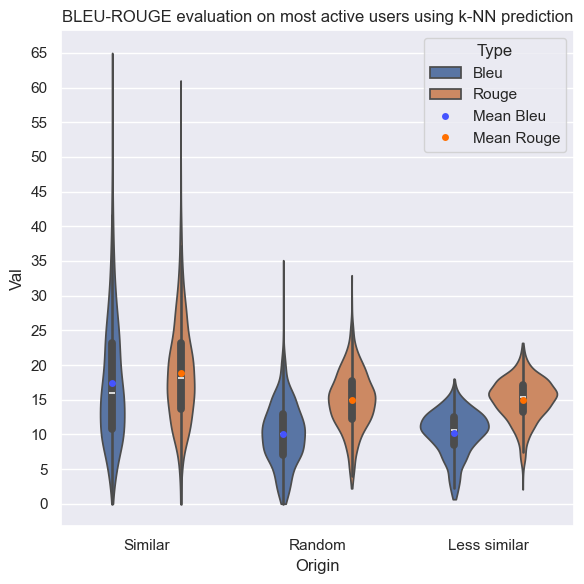

In [92]:
plot_bleu_rouge('most active', 'k-NN')

c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)
c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


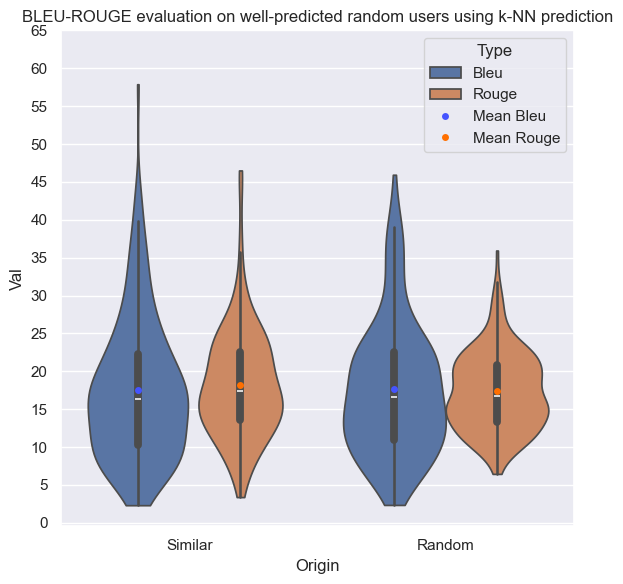

In [8]:
plot_bleu_rouge('random', 'k-NN',well_predicted=True)

c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)
c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


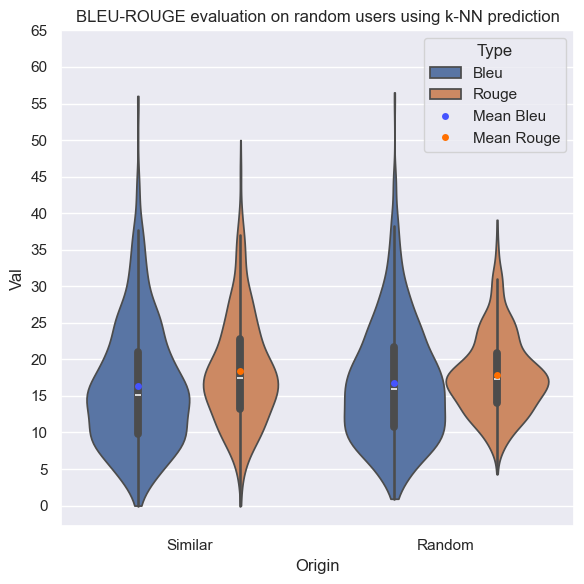

In [9]:
plot_bleu_rouge('random', 'k-NN')

## NMF

c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)
c:\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


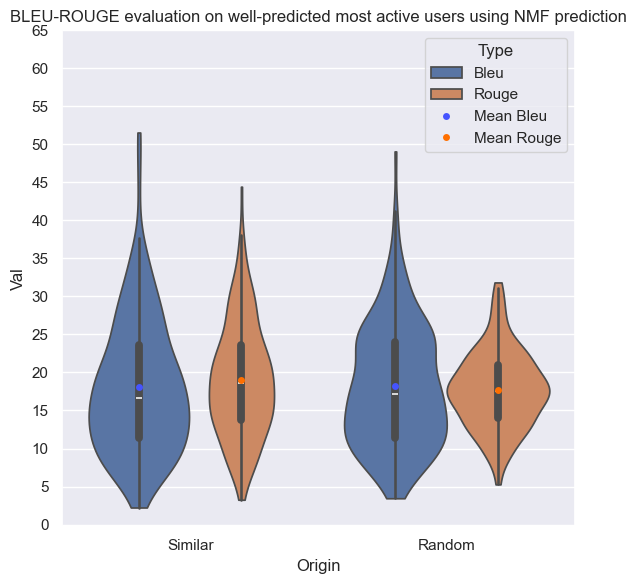

In [22]:
plot_bleu_rouge('most active', 'NMF',well_predicted=True)

c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)
c:\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


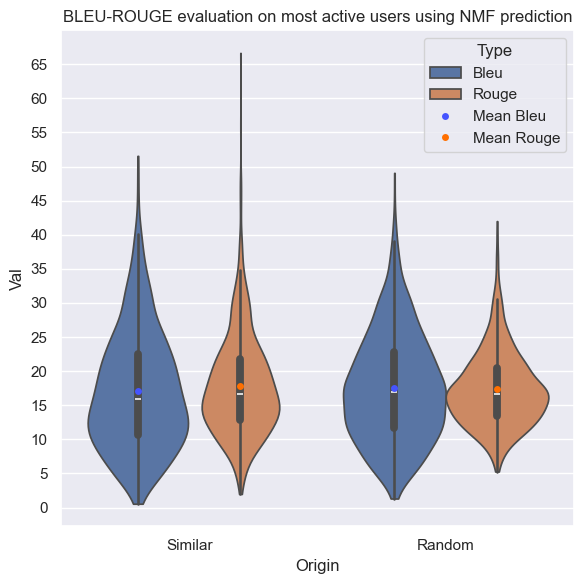

In [23]:
plot_bleu_rouge('most active', 'NMF')

c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)
c:\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


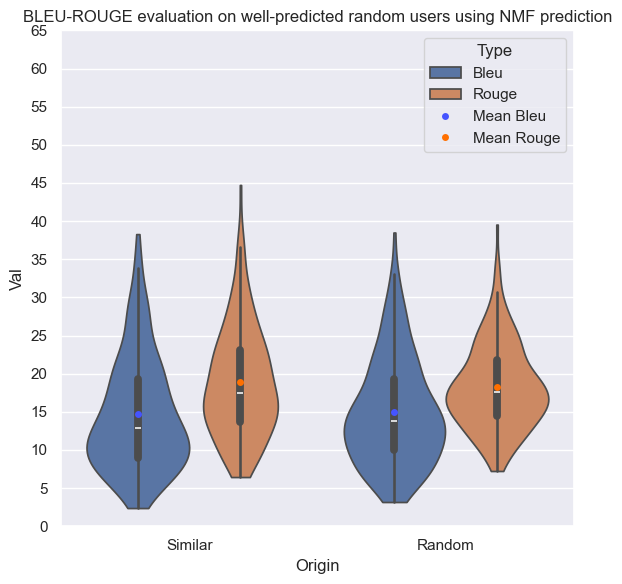

In [24]:
plot_bleu_rouge('random', 'NMF',well_predicted=True)

c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)
c:\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Python311\Lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)


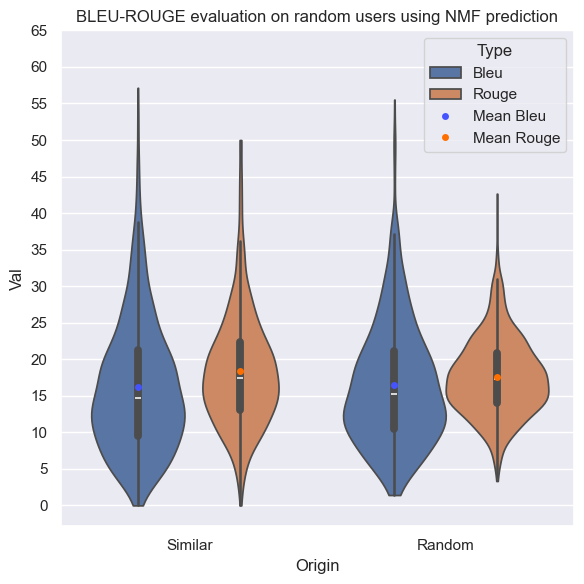

In [25]:
plot_bleu_rouge('random', 'NMF')

# Evaluation qualitative 

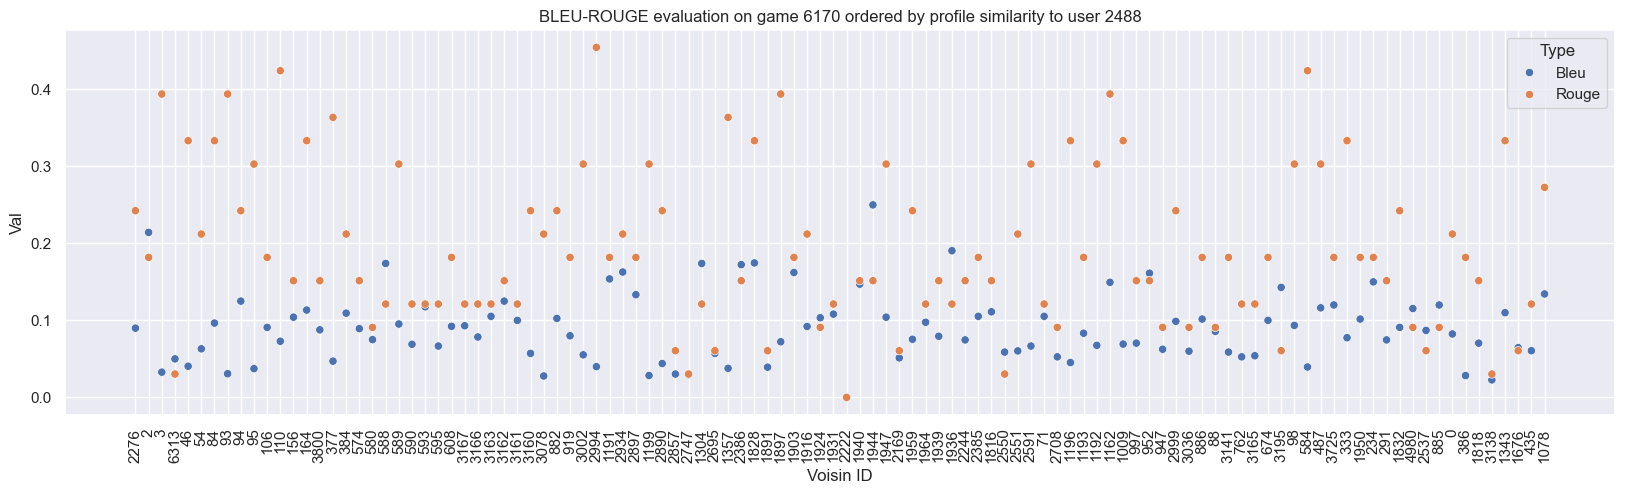

In [39]:
random.seed(None)
us_id = random.choice(rev_filter['User id'].to_numpy())
game_id = random.choice(rev_filter[rev_filter['User id'] == us_id]['Game id'].to_numpy())

# Top 5 users
indices = ind_to_id([520, 811, 401, 9, 863])
games = [6170, 6135, 8534, 9618, 9609]

us_id = indices[0]
game_id = games[0]


def get_lemma(user_id : int, game_id : int ) -> str:
    indx = rev_filter[(rev_filter['User id'] == user_id) & (rev_filter['Game id'] == game_id)].index[0]
    
    return lemmas.loc[indx, 'Comment']

def rouge(hyp : str, ref : str) -> float:
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform([hyp, ref])
    inter = np.sum(np.minimum(X.toarray()[0], X.toarray()[1]))
    return inter/np.sum(X.toarray()[0])

def bleu(hyp : str, ref : str) -> float:
    return rouge(ref,hyp)

def sim_evaluation(user_id=None, game_id=None, seed = 42):
    """
    Plots Bleu-1 & Rouge-1 score on a given game ordered by profile similarity to a user.
    """
    random.seed(seed)

    if(not user_id or not game_id):
        user_id = random.choice(rev_filter['User id'].to_numpy())
        game_id = game_id = random.choice(rev_filter[rev_filter['User id'] == us_id]['Game id'].to_numpy())

    sim = voters_sim(us_id, game_id)
    df = pd.DataFrame({'Voisin ID' : sim})
    hyp_lem = get_lemma(us_id, game_id)
    #df['Lemma'] = df['Voisin ID'].apply(lambda x : get_lemma(x, game_id))
    df['Bleu'] = df['Voisin ID'].apply(lambda x : bleu(hyp_lem, get_lemma(x,game_id)))
    df['Rouge'] = df['Voisin ID'].apply(lambda x : bleu(get_lemma(x,game_id), hyp_lem))
    df['Voisin ID'] = df['Voisin ID'].astype(str)
    df = pd.melt(df,id_vars=['Voisin ID'], value_vars=['Bleu', 'Rouge'],var_name="Type",value_name="Val")
    sns.set_theme(rc={'figure.figsize' : (20, 5)})
    ax = sns.scatterplot(df, x='Voisin ID', y ='Val', hue='Type')
    plt.xticks(rotation=90)
    plt.title(f"BLEU-ROUGE evaluation on game {game_id} ordered by profile similarity to user {user_id}")

sim_evaluation(indices[0], games[0])

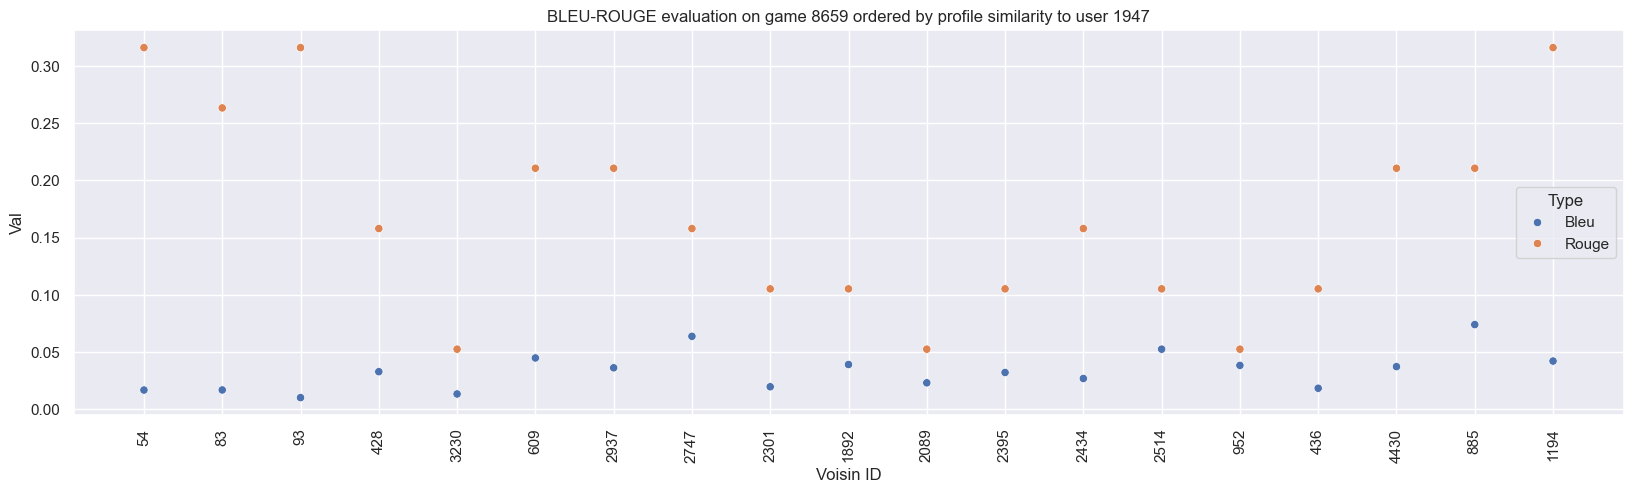

In [40]:
sim_evaluation()

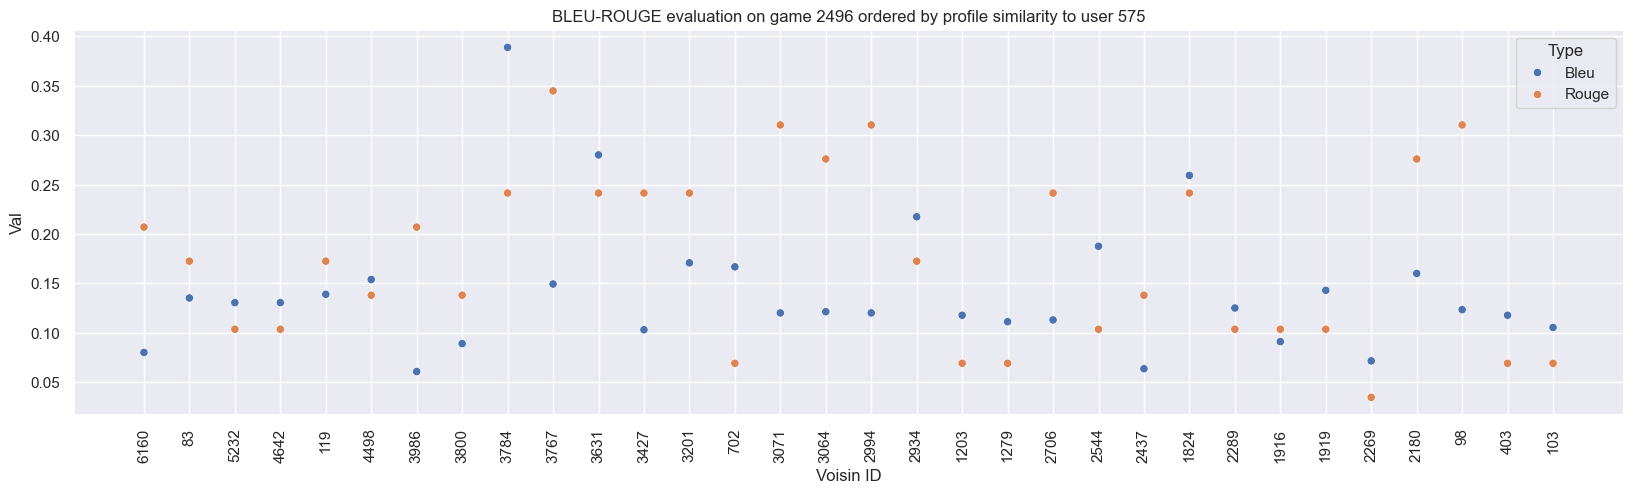

In [41]:
sim_evaluation(seed=2)

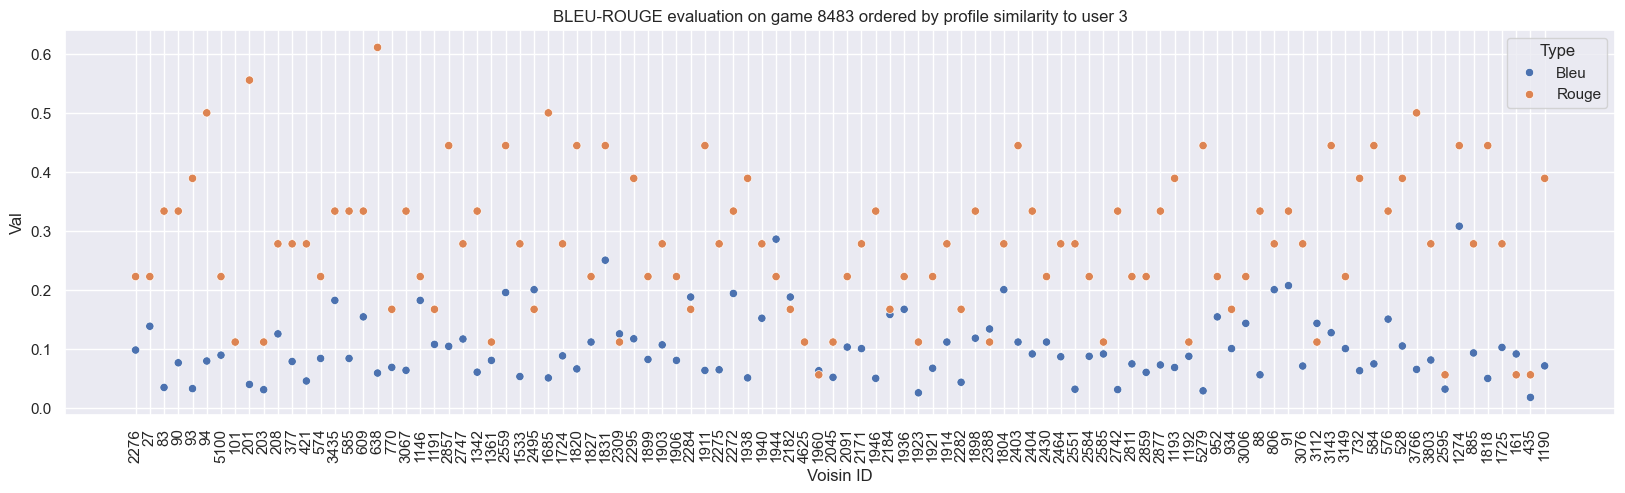

In [42]:
sim_evaluation(seed=3)